## transferlearning_002.ipynb

#### transferlearning_001에서는 원래 데이터셋에서 10%만의 데이터로 학습을 시키더라도
#### 우리가 직접 만들어본 모델에 원래 데이터셋을 학습시킨 것보다 더 좋은 성능 가진 다는 것을
#### transfer learning (전이학습)을 통해 알게 되었습니다. 
### feature extraction이 잘 되었다!

#### 이번 transfer learning 에서는 fine-tuning이라는 기법을 알아보려고 합니다.

In [6]:
from helper_functions import unzip_data, walk_through_dir, create_tensorboard_callback, plot_loss_curves

In [2]:
!wget -q https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

In [3]:
unzip_data("10_food_classes_10_percent.zip")

In [4]:
walk_through_dir("10_food_classes_10_percent")

10_food_classes_10_percent 폴더에는 2개의 폴더와 0개의 파일이 존재합니다.
10_food_classes_10_percent/test 폴더에는 10개의 폴더와 0개의 파일이 존재합니다.
10_food_classes_10_percent/test/ice_cream 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/test/chicken_curry 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/test/steak 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/test/sushi 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/test/chicken_wings 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/test/grilled_salmon 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/test/hamburger 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/test/pizza 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/test/ramen 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/test/fried_rice 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/train 폴더에는 10개의 폴더와 0개의 파일이 존재합니다.
10_food_classes_10_percent/train/ice_cream 폴더에는 0개의 폴더와 75개의 파일이 존재합니다.
10_food_classes_10_percent/train

In [11]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 30

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [34]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# transferlearning_001까지, 즉 지금까지 ImageDataGenerator를 사용했습니다.
# 잘 동작도 하고 많이 사용하는 방법입니다.
# transferlearning_002에서는 image_data_from_directory 라는 함수를 사용해 보겠습니다.

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMAGE_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMAGE_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### ImageDataGenerator : python generator
### tf.keras.preprocessing.image_dataset_from_directory : tf.data.Dataset 오브젝트

#### tf.data.Dataset API는 큰 데이터셋에 대해서 좀더 효율적입니다. 그래서 많이 사용합니다.
#### tf.data.Dataset API는 관련된 메서드들이 많이 존재합니다.

In [14]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

#### (None, 224, 224, 3) : None은 배치사이즈, 224는 높이, 224는 너비, 3은 컬러 채널(RGB)인 이미지의 텐서 shape)
#### (None, 10) : None은 배치 사이즈, 10은 가능한 리벨의 갯수 (우리가 실습하는 데이터셋은 10개의 종류가 있는 것을 자동으로 판단)인 텐서 shape
#### 이 텐서들은 모두 tf.float32 자료형을 가지고 있습니다.

#### batch_size가 None인 이유 : 학습하는 동안에만 사용하기 때문입니다.
#### None의 의미는 placeholder

In [15]:
# class_names() 메서드 : 클래스 목록화

train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# take() 메서드 : 데이터 배치의 사례를 확인하고자 할 때 사용
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[7.14387741e+01 7.94387741e+01 1.00438774e+02]
   [7.80918427e+01 8.60918427e+01 1.07091843e+02]
   [6.93418350e+01 7.79846954e+01 9.87704086e+01]
   ...
   [1.86857162e+02 1.74285690e+02 1.54642899e+02]
   [1.81285706e+02 1.70500031e+02 1.50428589e+02]
   [1.77183563e+02 1.71183563e+02 1.47183563e+02]]

  [[7.32142868e+01 8.12142868e+01 1.02214287e+02]
   [8.06326523e+01 8.86326523e+01 1.09632652e+02]
   [6.73418427e+01 7.59846954e+01 9.67704163e+01]
   ...
   [1.85214264e+02 1.72642792e+02 1.53000000e+02]
   [1.85647934e+02 1.74862259e+02 1.54790817e+02]
   [1.78499863e+02 1.72499863e+02 1.50499863e+02]]

  [[6.22806129e+01 7.02806168e+01 9.12806168e+01]
   [6.76020432e+01 7.56020432e+01 9.66020432e+01]
   [6.80000000e+01 7.66428604e+01 9.74285736e+01]
   ...
   [1.83168396e+02 1.70596924e+02 1.50954132e+02]
   [1.85841766e+02 1.75056091e+02 1.54984650e+02]
   [1.77010178e+02 1.71010178e+02 1.49010178e+02]]

  ...

  [[1.77724579e+02 1.34724579e+02 8.21531143e+01]
   [1

In [11]:
# Model 1
base_model = tf.keras.applications.EfficientNetB0(include_top = False) # False의 의미: 네트워크의 마지막 레이어 (출력층)를 개발자가 직접 만들겠다.

base_model.trainable = False    # 사전에 학습한 모델의 모든 가중치를 고정하겠다, 즉 변경하지 않겠다 (모델 그대로 사용하겠다.) 

inputs = tf.keras.layers.Input(
    shape = (224, 224, 3),
    name = "input_layer"
)

# rescaling, normalization은 모델이 필요할 때 사용한다.
# efficientent의 경우는 필요없고, 나머지 경우는 필요하다.(상황에 따라)

x = base_model(inputs)
print(f"base_model의 shape : {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

print(f"global_average_pooling_layer이후의 shape {x.shape}")

outputs = tf.keras.layers.Dense(
    10, 
    activation="softmax", 
    name = "output_layer"
)(x)

model_0 = tf.keras.Model(inputs, outputs)
# Functional API 방식으로 모델을 만든 것

model_0.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)
history_10_percent = model_0.fit(
    train_data_10_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data_10_percent,
    validation_steps = len(test_data_10_percent),
    callbacks = [create_tensorboard_callback(
        "transfer_learning", "10_percent_feature_extract"
    )]
)


base_model의 shape : (None, 7, 7, 1280)
global_average_pooling_layer이후의 shape (None, 1280)
TensorBoard 로그 파일을 저장한 디렉토리 : transfer_learning/10_percent_feature_extract/20210619-151110
Epoch 1/5
25/25 [==============================] - 197s 8s/step - loss: 1.9014 - accuracy: 0.4040 - val_loss: 1.3436 - val_accuracy: 0.6948
Epoch 2/5
25/25 [==============================] - 191s 8s/step - loss: 1.1376 - accuracy: 0.7480 - val_loss: 0.9122 - val_accuracy: 0.7912
Epoch 3/5
25/25 [==============================] - 211s 9s/step - loss: 0.8368 - accuracy: 0.8013 - val_loss: 0.7436 - val_accuracy: 0.8216
Epoch 4/5
25/25 [==============================] - 210s 9s/step - loss: 0.6663 - accuracy: 0.8480 - val_loss: 0.6567 - val_accuracy: 0.8324
Epoch 5/5
25/25 [==============================] - 200s 8s/step - loss: 0.5922 - accuracy: 0.8427 - val_loss: 0.6035 - val_accuracy: 0.8376


In [12]:
# 모델 어떻게 생겼는지 확인
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [13]:
base_model.summary()

e_expand[0][0]          
__________________________________________________________________________________________________
block5b_project_conv (Conv2D)   (None, None, None, 1 75264       block5b_se_excite[0][0]          
__________________________________________________________________________________________________
block5b_project_bn (BatchNormal (None, None, None, 1 448         block5b_project_conv[0][0]       
__________________________________________________________________________________________________
block5b_drop (Dropout)          (None, None, None, 1 0           block5b_project_bn[0][0]         
__________________________________________________________________________________________________
block5b_add (Add)               (None, None, None, 1 0           block5b_drop[0][0]               
                                                                 block5a_project_bn[0][0]         
____________________________________________________________________________________

In [15]:
# 모델 어떻게 생겼는지 확인
for layer_number, layer in enumerate(model_0.layers):
    print(layer_number, layer.name)

0 input_layer
1 efficientnetb0
2 global_average_pooling_layer
3 output_layer


In [14]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [21]:
def plot_loss_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="training loss")
    plt.plot(epochs, val_loss, label="validation loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="training accuracy")
    plt.plot(epochs, val_accuracy, label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

In [22]:
plot_loss_curves(history_10_percent)

In [24]:
# tf.keras.layers.GlobalAveragePooling2D() : 4차원 텐서를 2차원 텐서로 변환시켜줍니다. 이 때 값들의 평균을 사용합니다.

input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"random input tensor : {input_tensor}")

random input tensor : [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]


In [25]:
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled input tensor: {global_average_pooled_tensor}")

2D global average pooled input tensor: [[-0.09368646 -0.45840445 -0.28855976]]


In [30]:
print(f"{input_tensor.shape}")
print(f"{input_tensor.ndim}")
print(f"{global_average_pooled_tensor.shape}")
print(f"{global_average_pooled_tensor.ndim}")

(1, 4, 4, 3)
4
(1, 3)
2


In [33]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
# Model 2 : resNet
base_model = tf.keras.applications.ResNet50V2(include_top = False) # False의 의미: 네트워크의 마지막 레이어 (출력층)를 개발자가 직접 만들겠다.

base_model.trainable = False    # 사전에 학습한 모델의 모든 가중치를 고정하겠다, 즉 변경하지 않겠다 (모델 그대로 사용하겠다.) 

inputs = tf.keras.layers.Input(
    shape = (224, 224, 3),
    name = "input_layer"
)

# rescaling, normalization은 모델이 필요할 때 사용한다.
# efficientent의 경우는 필요없고, 나머지 경우는 필요하다.(상황에 따라)
x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)


x = base_model(x)
print(f"base_model의 shape : {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

print(f"global_average_pooling_layer이후의 shape {x.shape}")

outputs = tf.keras.layers.Dense(
    10, 
    activation="softmax", 
    name = "output_layer"
)(x)

model_0 = tf.keras.Model(inputs, outputs)
# Functional API 방식으로 모델을 만든 것

model_0.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)
history_10_percent = model_0.fit(
    train_data_10_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data_10_percent,
    validation_steps = len(test_data_10_percent),
    callbacks = [create_tensorboard_callback(
        "transfer_learning", "10_percent_feature_extract"
    )]
)


base_model의 shape : (None, 7, 7, 2048)
global_average_pooling_layer이후의 shape (None, 2048)


NameError: name 'train_data_10_percent' is not defined

In [36]:
!python3 -m tensorboard.main dev upload --logdir ./tensorflow_hub/ --name ResNet50V2 --one_shot

Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/f7q2EoR5Qdu1ZrDQWBdD1g/

[2021-06-19T16:57:29] Started scanning logdir.
[2021-06-19T16:57:35] Total uploaded: 90 scalars, 0 tensors, 3 binary objects (7.6 MB)
[2021-06-19T16:57:35] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/f7q2EoR5Qdu1ZrDQWBdD1g/


#### 우리는 전이학습의 놀라운 효과를 확인했다. 전체 중 10%의 데이터와 5라는 epoch만으로도 거의 90% 가까운 accuracy를 얻었다.
#### 1%라면 어떨까?

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2021-06-20 09:16:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 34.64.4.80, 34.64.4.48, 34.64.4.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|34.64.4.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: `10_food_classes_1_percent.zip'

10_food_classes_1_p 100%[===================>] 127.42M  29.0MB/s    in 8.0s    

2021-06-20 09:16:39 (15.9 MB/s) - `10_food_classes_1_percent.zip' saved [133612354/133612354]



In [8]:
unzip_data("10_food_classes_1_percent.zip")

In [9]:
walk_through_dir("10_food_classes_1_percent")

10_food_classes_1_percent 폴더에는 2개의 폴더와 0개의 파일이 존재합니다.
10_food_classes_1_percent/test 폴더에는 10개의 폴더와 0개의 파일이 존재합니다.
10_food_classes_1_percent/test/ice_cream 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_1_percent/test/chicken_curry 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_1_percent/test/steak 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_1_percent/test/sushi 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_1_percent/test/chicken_wings 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_1_percent/test/grilled_salmon 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_1_percent/test/hamburger 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_1_percent/test/pizza 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_1_percent/test/ramen 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_1_percent/test/fried_rice 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_1_percent/train 폴더에는 10개의 폴더와 0개의 파일이 존재합니다.
10_food_classes_1_percent/train/ice_cream 폴더에는 0개의 폴더와 7개의 파일이 존재합니다.
10_food_classes_1_percent/train/chicken_curry 폴

In [19]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"


In [20]:
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    directory = train_dir_1_percent,
    label_mode = "categorical"
)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    directory = test_dir_1_percent,
    label_mode = "categorical"

)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [21]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [36]:
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomWidth(0.2)
], name="data_augmentation")

(-0.5, 511.5, 382.5, -0.5)

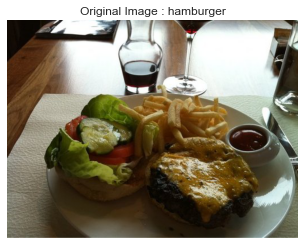

In [48]:
# augmentation 된 이미지 확인
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original Image : {target_class}")
plt.axis(False)



(-0.5, 588.5, 382.5, -0.5)

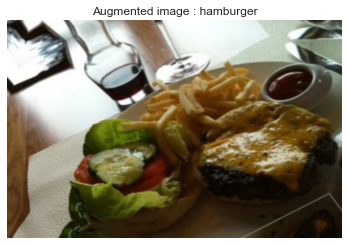

In [49]:
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # ndims = 4, 즉 shape가 (None, height, width, 3) 인 것을 필요로 했다.
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # augmentation한 후에 normalization을 한 것
plt.title(f"Augmented image : {target_class}")
plt.axis(False)

In [38]:
# Model 1
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape = input_shape, name = "model_1_input_layer")

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name = "model_1_global_average_pooling_layer")(x)

outputs = layers.Dense(10, activation = "softmax", name = "model_1_output_layer")(x)

model_1 = keras.Model(inputs, outputs)

# 컴파일과 fitting
model_1.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)


In [40]:
history_1_percent = model_1.fit(
    train_data_1_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_1_percent),
    validation_data = test_data_1_percent,
    validation_steps = len(test_data_1_percent),
    callbacks = [create_tensorboard_callback(
        "transfer_learning", "1_percent_data_augment"
    )]
)

TensorBoard 로그 파일을 저장한 디렉토리 : transfer_learning/1_percent_data_augment/20210620-095728
Epoch 1/5
3/3 [==============================] - 106s 49s/step - loss: 2.2958 - accuracy: 0.1429 - val_loss: 2.1442 - val_accuracy: 0.2200
Epoch 2/5
3/3 [==============================] - 102s 50s/step - loss: 1.9839 - accuracy: 0.3714 - val_loss: 2.0356 - val_accuracy: 0.3012
Epoch 3/5
3/3 [==============================] - 109s 54s/step - loss: 1.9065 - accuracy: 0.3714 - val_loss: 1.9441 - val_accuracy: 0.3580
Epoch 4/5
3/3 [==============================] - 111s 55s/step - loss: 1.7144 - accuracy: 0.5857 - val_loss: 1.8595 - val_accuracy: 0.4180
Epoch 5/5
3/3 [==============================] - 103s 51s/step - loss: 1.6284 - accuracy: 0.6571 - val_loss: 1.7777 - val_accuracy: 0.4772


In [41]:
model_1.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1_input_layer (InputLa [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 224, None, 3)      0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
model_1_global_average_pooli (None, 1280)              0         
_________________________________________________________________
model_1_output_layer (Dense) (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [42]:
result_1_percent_data_aug = model_1.evaluate(test_data_1_percent)

79/79 [==============================] - 123s 2s/step - loss: 1.7777 - accuracy: 0.4772


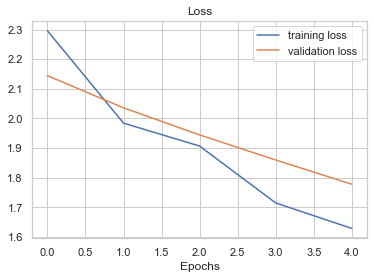

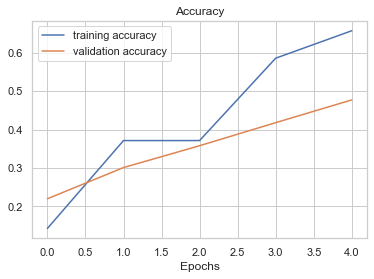

In [45]:
 plot_loss_curves(history_1_percent)

In [ ]:
# Model 2 : 10%의 데이터 + Data Augmentation 
